In [ ]:
# 1. Read in and clean London neighbourhood data

In [3]:
import numpy as np #for handling data in a vectorized manner
import pandas as pd #for data analysis
pd.set_option('display.max_columns', None) #show all columns when displaying dataframe
pd.set_option('display.max_rows', None)
import requests #for handling requests
import matplotlib.pyplot as plt #for simple plots
import matplotlib.cm as cm #for accessing colourmaps
import matplotlib.colors as colors #for altering colors
from sklearn.cluster import KMeans #for k-means
from sklearn.preprocessing import OneHotEncoder
import folium #for map rendering
import geocoder #for finding coordinates of sites
import json #for handling json files
from pandas.io.json import json_normalize #transform JSON file into a pandas dataframe

In [3]:
#read and wrangle data from .csv

data = pd.read_csv('London_postcodes.csv')
print(data.shape)
data.head()

(320915, 45)


,Postcode,In Use?,Latitude,Longitude,Easting,Northing,Grid Ref,County,District,Ward,District Code,Ward Code,Country,County Code,Constituency,Introduced,Terminated,Parish,National Park,Population,Households,Built up area,Built up sub-division,Lower layer super output area,Rural/urban,Region,Altitude,London zone,LSOA Code,Local authority,MSOA Code,Middle layer super output area,Parish Code,Census output area,Constituency Code,Index of Multiple Deprivation,Quality,User Type,Last updated,Nearest station,Distance to station,Postcode area,Postcode district,Police force,Water company
0,BR1 1AA,Yes,51.401546,0.015415,540291,168873,TQ402688,Greater London,Bromley,Bromley Town,E09000006,E05000109,England,E11000009,Bromley and Chislehurst,2016-05-01,NaN,"Bromley, unparished area",NaN,NaN,NaN,Greater London,Bromley,Bromley 018B,Urban major conurbation,London,71,5,E01000675,NaN,E02000144,Bromley 018,E43000196,E00003264,E14000604,20532,1,0,2019-08-24,Bromley South,0.218257,BR,BR1,Metropolitan Police,Thames Water
1,BR1 1AB,Yes,51.406333,0.015208,540262,169405,TQ402694,Greater London,Bromley,Bromley Town,E09000006,E05000109,England,E11000009,Bromley and Chislehurst,2012-03-01,NaN,"Bromley, unparished area",NaN,NaN,NaN,Greater London,Bromley,Bromley 008B,Urban major conurbation,London,71,4,E01000676,NaN,E02000134,Bromley 008,E43000196,E00003255,E14000604,10169,1,0,2019-08-24,Bromley North,0.253666,BR,BR1,Metropolitan Police,Thames Water
2,BR1 1AD,No,51.400057,0.016715,540386,168710,TQ403687,Greater London,Bromley,Bromley Town,E09000006,E05000109,England,E11000009,Bromley and Chislehurst,2014-09-01,2017-09-01,"Bromley, unparished area",NaN,NaN,NaN,Greater London,Bromley,Bromley 018B,Urban major conurbation,London,53,5,E01000675,NaN,E02000144,Bromley 018,E43000196,E00003264,E14000604,20532,1,1,2019-08-24,Bromley South,0.044559,BR,BR1,Metropolitan Police,NaN
3,BR1 1AE,Yes,51.404543,0.014195,540197,169204,TQ401692,Greater London,Bromley,Bromley Town,E09000006,E05000109,England,E11000009,Bromley and Chislehurst,2008-08-01,NaN,"Bromley, unparished area",NaN,34.0,21.0,Greater London,Bromley,Bromley 018C,Urban major conurbation,London,71,4,E01000677,NaN,E02000144,Bromley 018,E43000196,E00003266,E14000604,19350,1,0,2019-08-24,Bromley North,0.462939,BR,BR1,Metropolitan Police,Thames Water
4,BR1 1AF,Yes,51.401392,0.014948,540259,168855,TQ402688,Greater London,Bromley,Bromley Town,E09000006,E05000109,England,E11000009,Bromley and Chislehurst,2015-05-01,NaN,"Bromley, unparished area",NaN,NaN,NaN,Greater London,Bromley,Bromley 018B,Urban major conurbation,London,58,5,E01000675,NaN,E02000144,Bromley 018,E43000196,E00003264,E14000604,20532,1,0,2019-08-24,Bromley South,0.227664,BR,BR1,Metropolitan Police,Thames Water


In [7]:
data = data.groupby('Ward').mean().reset_index() #we will divide london 
#into electoral wards, and determine the coordinates of each ward by
#averaging over the coordinates of all postcodes associated with that ward
data = data.iloc[:, :3]
data.head()

,Ward,Latitude,Longitude
0,Abbey,51.480969,-0.048108
1,Abbey Road,51.534409,-0.178194
2,Abbey Wood,51.490611,0.113839
3,Abingdon,51.497900,-0.197484
4,Acton Central,51.513529,-0.269309


In [8]:
data.to_pickle('london_clustering') #store data in pickle

In [4]:
data = pd.read_pickle('london_clustering')
data.head()

,Ward,Latitude,Longitude
0,Abbey,51.480969,-0.048108
1,Abbey Road,51.534409,-0.178194
2,Abbey Wood,51.490611,0.113839
3,Abingdon,51.497900,-0.197484
4,Acton Central,51.513529,-0.269309


In [5]:
#create map of neighbourhoods in london using latitude and longitude values

g = geocoder.arcgis('London, United Kingdom') #find general coordinates of London
lat_lng = g.latlng

map_london = folium.Map(location=[lat_lng[0], lat_lng[1]], zoom_start=10, control_scale = True) #create map 

# add markers to map
for lat, lng, neighborhood in zip(data['Latitude'], data['Longitude'], data['Ward']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

In [1]:
#2. Prepare foursquare credentials and obtain information on venues

CLIENT_ID = '...' # your Foursquare ID
CLIENT_SECRET = '...' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ...
CLIENT_SECRET:...


In [12]:
#lets get the top 50 venues within 500m of each ward using Foursquare API. Wards in Central London tend
#to be a lot closer together than further out. So in some cases we will have some overlapping

LIMIT = 50 #limit number of results to 50
category_section = 'food' #look for food establishments

def getNearbyVenues(wards, latitudes, longitudes, radius = 500): #will pass pandas series to this function
    venues_list = []
    for ward, lat, lng, in zip(wards, latitudes, longitudes):
        print(ward)
        #create the API request URL
        try:
           url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&section={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, radius, LIMIT, category_section)
        
           # make the GET request
           results = requests.get(url).json()['response']['groups'][0]['items']
    
           # extract relevant information for nearby venues
           venues_list.append([(
           ward,
           lat,
           lng,
           v['venue']['name'],
           v['venue']['location']['lat'], 
           v['venue']['location']['lng'],  
           v['venue']['categories'][0]['name']) for v in results])
        
        except: continue
    
    #convert list into dataframe
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Ward', 
                  'Ward Latitude', 
                  'Ward Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

london_venues = getNearbyVenues(wards=data['Ward'],
                                 latitudes=data['Latitude'],
                                 longitudes=data['Longitude'])

london_venues.head()
london_venues.to_pickle('london_venues') #store data in pickle

Abbey
Abbey Road
Abbey Wood
Abingdon
Acton Central
Addiscombe East
Addiscombe West
Addison
Aldborough
Aldersgate
Aldgate
Alexandra
Alibon
Alperton
Askew
Avonmore and Brook Green
Balham
Barkingside
Barnehurst
Barnes
Barnhill
Barnsbury
Bassishaw
Bayswater
Beckton
Becontree
Beddington North
Beddington South
Bedfont
Bedford
Bellingham
Belmont
Belsize
Belvedere
Bensham Manor
Berrylands
Bethnal Green
Beverley
Bexleyheath
Bickley
Biggin Hill
Billingsgate
Bishop's
Bishopsgate
Blackfen & Lamorbey
Blackheath
Blackheath Westcombe
Blackwall & Cubitt Town
Blendon & Penhill
Bloomsbury
Boleyn
Borough & Bankside
Botwell
Bounds Green
Bow East
Bow West
Bowes
Bread Street
Brentford
Bridge
Brixton Hill
Broad Green
Broad Street
Brockley
Bromley Common and Keston
Bromley North
Bromley South
Bromley Town
Brompton & Hans Town
Brondesbury Park
Brooklands
Brownswood
Bruce Grove
Brunel
Brunswick Park
Bryanston and Dorset Square
Bunhill
Burnt Oak
Bush Hill Park
Caledonian
Camberwell Green
Camden Town with Primros

Woolwich Riverside
Worcester Park
Wormholt and White City
Yeading
Yiewsley


In [20]:
london_venues = pd.read_pickle('london_venues')
print(london_venues.shape)
london_venues.head()

(8374, 7)


,Ward,Ward Latitude,Ward Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbey,51.480969,-0.048108,Hong Kong City,51.477575,-0.051205,Chinese Restaurant
1,Abbey,51.480969,-0.048108,Queens of Cue,51.483668,-0.051481,BBQ Joint
2,Abbey,51.480969,-0.048108,Halepi,51.484541,-0.050571,Greek Restaurant
3,Abbey,51.480969,-0.048108,Pho Thuy Tay Cafe,51.478664,-0.053966,Vietnamese Restaurant
4,Abbey,51.480969,-0.048108,Big T's Jamaican Cookhouse,51.480439,-0.041226,Caribbean Restaurant


In [27]:
#perform one hot encoding using pd.get_dummies command

london_onehot = pd.get_dummies(london_venues['Venue Category'], prefix = "", prefix_sep = "") #prefix refers to 
#new data column name

#next five lines show what needs to be done using OnceHotEncoder method
#encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
#london_onehot = pd.DataFrame(encoder.fit_transform(np.array(london_venues['Venue Category']).reshape(-1,1)))
#column_names = encoder.get_feature_names(['Venue Category'])
#london_onehot.columns = [column_name[15:] for column_name in column_names]
#london_onehot = london_onehot.astype('int')

london_onehot['Ward'] = london_venues['Ward'] #add postcodes to onehot encoded dataframe
new_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1]) #next two lines are for rearranging 
#columns
london_onehot = london_onehot[new_columns]

london_onehot.head()


,Ward,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brasserie,Brazilian Restaurant,Breakfast Spot,Buffet,Bulgarian Restaurant,Burger Joint,Burmese Restaurant,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chaat Place,Chinese Restaurant,Churrascaria,Colombian Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Currywurst Joint,Czech Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Grilled Meat Restaurant,Halal Restaurant,Himalayan Restaurant,Hot Dog Joint,Hunan Restaurant,Hungarian Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Iraqi Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Kurdish Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mamak Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mineiro Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Okonomiyaki Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pet Café,Pizza Place,Poke Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Romanian Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Scottish Restaurant,Seafood Restaurant,Shaanxi Restaurant,Snack Place,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Xinjiang Restaurant,Yakitori Restaurant
0,Abbey,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Abbey,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Abbey,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Abbey,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,Abbey,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
#next group rows by ward

london_grouped = london_onehot.groupby('Ward').sum().reset_index()

#lets restrict data to columns with 'Restaurant' in their name: 
#there are not many other columns which are useful for
#identifying the type of food anyway

london_grouped = pd.concat([london_grouped['Ward'],london_grouped.filter(regex = 'Restaurant')], axis = 1)
print(london_grouped.shape)
london_grouped.head()

(604, 99)


,Ward,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Belgian Restaurant,Brazilian Restaurant,Bulgarian Restaurant,Burmese Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Grilled Meat Restaurant,Halal Restaurant,Himalayan Restaurant,Hunan Restaurant,Hungarian Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Iraqi Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Kurdish Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mamak Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mineiro Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Okonomiyaki Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Romanian Restaurant,Russian Restaurant,Scandinavian Restaurant,Scottish Restaurant,Seafood Restaurant,Shaanxi Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Xinjiang Restaurant,Yakitori Restaurant
0,Abbey,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,Abbey Road,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,Abbey Wood,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Abingdon,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,1,0,0,2,0,1,0,2,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
4,Acton Central,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
#Comfort Food, Fast Food, Gluten-free, Grilled Meat, Molecular Gastronomy, Restaurant, Seafood, Theme Restaurant, 
#Vegetarian / Vegan Restaurant will be dropped from the data set as they don't tell us much about demographics

london_grouped = london_grouped.drop(['Comfort Food Restaurant', 'Fast Food Restaurant', 'Gluten-free Restaurant', 
                                      'Grilled Meat Restaurant', 'Molecular Gastronomy Restaurant', 'Restaurant', 
                                      'Seafood Restaurant', 'Theme Restaurant', 'Vegetarian / Vegan Restaurant' ], 
                                     axis = 1)
print(london_grouped.shape)
london_grouped.head()

(604, 90)


,Ward,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Belgian Restaurant,Brazilian Restaurant,Bulgarian Restaurant,Burmese Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Halal Restaurant,Himalayan Restaurant,Hunan Restaurant,Hungarian Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Iraqi Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Kurdish Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mamak Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mineiro Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Okonomiyaki Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Romanian Restaurant,Russian Restaurant,Scandinavian Restaurant,Scottish Restaurant,Shaanxi Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vietnamese Restaurant,Xinjiang Restaurant,Yakitori Restaurant
0,Abbey,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,Abbey Road,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,Abbey Wood,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Abingdon,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,1,0,0,2,0,1,0,2,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
4,Acton Central,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
#Lets classify venues in terms of bigger geographical regions 
#i.e. West European/North American, East European, Middle Eastern/North 
#African, South/Central American, East Asian, South Asian, South-East 
#Asian, African, Carribean?
#Australian will be classified as European/North American, 
#Asian will be classified as South-East Asian, 
#Doner will be classified as Middle Eastern,
#Halal will be classified as Middle Eastern,
#Greek will be classified as Middle Eastern,
#Himalayan will be classified as South Asian,
#Indian Chinese will be classified as South Asian,
#Mediterranean will be classified as Middle Eastern,
#Modern European will be classified as West European,
#New American will be classified as West European
#Caucasian will be classified as Middle Eastern
#Dumpling will be classified as East Asian
#Empanada will be classified as South American
#Ethiopean will be classified as African
#Russia will be classified as Eastern Europe
#Vietnamese is classified as South-East Asian

new_column_names = ['West European/North American', 'East European', 'Middle Eastern/North African', 
                    'South/Central American', 'East Asian', 'South-East Asian', 'South Asian', 'African', 'Carribean']

london_grouped.columns = ['Ward', new_column_names[6], new_column_names[7], new_column_names[0], 
                          new_column_names[3], new_column_names[3], new_column_names[5], new_column_names[0], 
                          new_column_names[0], new_column_names[0], new_column_names[3], new_column_names[1], 
                          new_column_names[5], new_column_names[0], new_column_names[4], new_column_names[8], 
                          new_column_names[2], new_column_names[4], new_column_names[3], new_column_names[3], 
                          new_column_names[1], new_column_names[4], new_column_names[2], new_column_names[4], 
                          new_column_names[1], new_column_names[3], new_column_names[0], new_column_names[7], 
                          new_column_names[2], new_column_names[5], new_column_names[0], new_column_names[0], 
                          new_column_names[2], new_column_names[2], new_column_names[6], new_column_names[4], 
                          new_column_names[1], new_column_names[6], new_column_names[6], new_column_names[5], 
                          new_column_names[2], new_column_names[2], new_column_names[0], new_column_names[4],   
                          new_column_names[2], new_column_names[2], new_column_names[4], new_column_names[2], 
                          new_column_names[2], new_column_names[3], new_column_names[2], new_column_names[5],
                          new_column_names[5], new_column_names[2], new_column_names[3], new_column_names[2],
                          new_column_names[3], new_column_names[0], new_column_names[2], new_column_names[0],
                          new_column_names[6], new_column_names[4], new_column_names[0], new_column_names[6],
                          new_column_names[2], new_column_names[3], new_column_names[1], new_column_names[0],
                          new_column_names[4], new_column_names[1], new_column_names[1], new_column_names[0],
                          new_column_names[0], new_column_names[4], new_column_names[3], new_column_names[6],
                          new_column_names[0], new_column_names[0], new_column_names[6], new_column_names[4],
                          new_column_names[4], new_column_names[4], new_column_names[0], new_column_names[5],
                          new_column_names[2], new_column_names[4], new_column_names[1], new_column_names[5],
                          new_column_names[4], new_column_names[4]]  

london_grouped = london_grouped.groupby(london_grouped.columns, axis = 1).sum() #sum up columns with same name
london_grouped.shape

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexes/base.py:2657: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return self._engine.get_loc(key)


(604, 10)

In [20]:
#Make postcode left most column again
london_grouped = london_grouped[['Ward', 'African', 'Carribean', 'East Asian', 'East European',
       'Middle Eastern/North African', 'South Asian','South-East Asian', 'South/Central American',
       'West European/North American']]
                     
london_grouped.to_pickle('london_grouped') #store data in pickle
print(london_grouped.shape)
london_grouped.head()

(604, 10)


,Ward,African,Carribean,East Asian,East European,Middle Eastern/North African,South Asian,South-East Asian,South/Central American,West European/North American
0,Abbey,0,1,1,0,1,0,1,0,0
1,Abbey Road,0,0,0,0,4,0,0,0,1
2,Abbey Wood,0,0,0,0,0,0,0,0,0
3,Abingdon,0,0,1,0,6,0,2,0,10
4,Acton Central,0,0,2,0,0,1,0,0,0


In [5]:
london_grouped = pd.read_pickle('london_grouped')
print(london_grouped.shape)
london_grouped.head()

(604, 10)


,Ward,African,Carribean,East Asian,East European,Middle Eastern/North African,South Asian,South-East Asian,South/Central American,West European/North American
0,Abbey,0,1,1,0,1,0,1,0,0
1,Abbey Road,0,0,0,0,4,0,0,0,1
2,Abbey Wood,0,0,0,0,0,0,0,0,0
3,Abingdon,0,0,1,0,6,0,2,0,10
4,Acton Central,0,0,2,0,0,1,0,0,0


In [6]:
#Lets drop the West European/North American columns: the UK is by definition one of these countries
#so a business would assume there will always be room for that part of the market

london_grouped = london_grouped.drop('West European/North American', axis = 1)
london_grouped.head()

,Ward,African,Carribean,East Asian,East European,Middle Eastern/North African,South Asian,South-East Asian,South/Central American
0,Abbey,0,1,1,0,1,0,1,0
1,Abbey Road,0,0,0,0,4,0,0,0
2,Abbey Wood,0,0,0,0,0,0,0,0
3,Abingdon,0,0,1,0,6,0,2,0
4,Acton Central,0,0,2,0,0,1,0,0


In [8]:
#lets write a function to sort the venues in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [10]:
#create dataframe displaying top 8 venues for each ward (since only 8 'classes' left)

num_top_venues = 8

indicators = ['st', 'nd', 'rd'] #for 1'st', 2'nd', and 3'rd' for columns in to be made dataframe
 
#create column names
columns = ['Ward']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1,indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
#create new dataframe
wards_venues_sorted = pd.DataFrame(columns = columns)
wards_venues_sorted['Ward'] = london_grouped['Ward']

for ind in np.arange(london_grouped.shape[0]):
    wards_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

print(wards_venues_sorted.shape)
wards_venues_sorted.head(600)

(604, 9)


,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Abbey,South-East Asian,Middle Eastern/North African,East Asian,Carribean,South/Central American,South Asian,East European,African
1,Abbey Road,Middle Eastern/North African,South/Central American,South-East Asian,South Asian,East European,East Asian,Carribean,African
2,Abbey Wood,South/Central American,South-East Asian,South Asian,Middle Eastern/North African,East European,East Asian,Carribean,African
3,Abingdon,Middle Eastern/North African,South-East Asian,East Asian,South/Central American,South Asian,East European,Carribean,African
4,Acton Central,East Asian,South Asian,South/Central American,South-East Asian,Middle Eastern/North African,East European,Carribean,African
5,Addiscombe East,South Asian,East Asian,South/Central American,South-East Asian,Middle Eastern/North African,East European,Carribean,African
6,Addiscombe West,South-East Asian,South Asian,Middle Eastern/North African,East Asian,South/Central American,East European,Carribean,African
7,Addison,East Asian,South-East Asian,South Asian,Middle Eastern/North African,South/Central American,East European,Carribean,African
8,Aldborough,South/Central American,South-East Asian,South Asian,Middle Eastern/North African,East European,East Asian,Carribean,African
9,Aldersgate,East Asian,South-East Asian,Middle Eastern/North African,South/Central American,South Asian,East European,Carribean,African


In [7]:
#3. try k_means clustering for different k

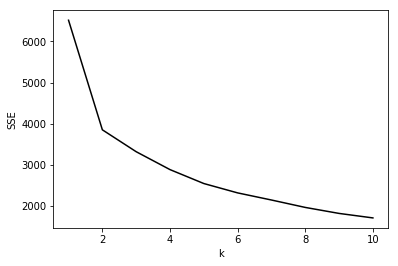

In [8]:
london_grouped_clusters = london_grouped.drop(['Ward'], 1) #drop postcodes column
k_means_errors = [] #list to store calculated sum of squares error from clustering
for clusters in [*range(1,11)]:
   k_means = KMeans(n_clusters= clusters, random_state=0).fit(london_grouped_clusters) #run kmeans algorithm
   k_means_errors.append(k_means.inertia_) #append SSE error to list
    
plt.plot([*range(1,11)], k_means_errors, 'k')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

#kmeans.labels_ #check cluster labels generated for each row in the dataframe

In [9]:
#so 5 clusters appears best, lets continue onwards with k=5

k_means = KMeans(n_clusters= 5, random_state=0).fit(london_grouped_clusters) #run kmeans algorithm
k_means.labels_

array([0, 2, 0, 3, 0, 0, 2, 2, 0, 2, 3, 3, 0, 4, 2, 4, 4, 0, 0, 1, 1, 3, 0,
       0, 4, 4, 0, 0, 0, 4, 4, 0, 0, 1, 0, 0, 0, 2, 1, 1, 0, 4, 0, 0, 4, 1,
       0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 4, 0, 0, 0, 2, 3, 4, 0, 0, 0, 0,
       0, 3, 1, 0, 0, 0, 3, 2, 1, 2, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 3, 4, 2,
       0, 3, 0, 0, 3, 0, 2, 2, 1, 0, 1, 0, 0, 4, 2, 0, 0, 0, 0, 1, 1, 2, 3,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 3, 2, 0, 4, 1, 0, 0, 0, 0,
       0, 2, 0, 1, 0, 0, 0, 2, 0, 4, 0, 2, 0, 0, 4, 4, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 4, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2,
       4, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 4, 4, 4, 4, 0, 0, 4, 2,
       2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 4,
       2, 3, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 4, 0, 0, 0,
       0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0, 2, 2, 4, 0, 4, 1, 0, 3, 0, 0,
       0, 0,

In [10]:
#create new dataframe which includes clusters as well as top 8 venues

wards_venues_sorted.insert(0, 'Cluster Labels', k_means.labels_) #insert column at index 0
london_merged = data
london_merged = london_merged.join(wards_venues_sorted.set_index('Ward'), on = 'Ward')
london_merged = london_merged.dropna().reset_index() #a row of NaNs was added in the process which needs to be dropped
london_merged['Cluster Labels'] = london_merged['Cluster Labels'].astype('int') #in this process the 'Cluster Labels' 
#integer values were converted to floats, so convert back to integers
london_merged.head()

,index,Ward,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,0,Abbey,51.480969,-0.048108,0,South-East Asian,Middle Eastern/North African,East Asian,Carribean,South/Central American,South Asian,East European,African
1,1,Abbey Road,51.534409,-0.178194,2,Middle Eastern/North African,South/Central American,South-East Asian,South Asian,East European,East Asian,Carribean,African
2,2,Abbey Wood,51.490611,0.113839,0,South/Central American,South-East Asian,South Asian,Middle Eastern/North African,East European,East Asian,Carribean,African
3,3,Abingdon,51.497900,-0.197484,3,Middle Eastern/North African,South-East Asian,East Asian,South/Central American,South Asian,East European,Carribean,African
4,4,Acton Central,51.513529,-0.269309,0,East Asian,South Asian,South/Central American,South-East Asian,Middle Eastern/North African,East European,Carribean,African


In [11]:
#visualize clusters

g = geocoder.arcgis('London, United Kingdom') #arcgis api seems to be more reliable than google
lat_lng = g.latlng

map_clusters = folium.Map(location=[lat_lng[0], lat_lng[1]], zoom_start=10, control_scale = True)

# set color scheme for the clusters
x = np.arange(clusters)
ys = [i + x + (i*x)**2 for i in range(clusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
colours = ['black', 'blue', 'red', 'green', 'purple']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Ward'], 
                                  london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color=colours[cluster-1],
        fill=True,
        fill_color=colours[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [12]:
#cluster 0(purple), cluster 1(black), cluster 2(blue), cluster 3(red), cluster 4(green)

In [13]:
#cluster 0 (purple)

a = london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[1] + 
    list(range(5, london_merged.shape[1]))]]
a.head()

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Abbey,South-East Asian,Middle Eastern/North African,East Asian,Carribean,South/Central American,South Asian,East European,African
2,Abbey Wood,South/Central American,South-East Asian,South Asian,Middle Eastern/North African,East European,East Asian,Carribean,African
4,Acton Central,East Asian,South Asian,South/Central American,South-East Asian,Middle Eastern/North African,East European,Carribean,African
5,Addiscombe East,South Asian,East Asian,South/Central American,South-East Asian,Middle Eastern/North African,East European,Carribean,African
8,Aldborough,South/Central American,South-East Asian,South Asian,Middle Eastern/North African,East European,East Asian,Carribean,African


In [63]:
#look at top 3 most common venues

#This function will produce a dataframe with a column of venue types and the amount of this type of venue which forms
#part of the 1st, 2nd, 3rd Most Common Venues
def top_3(a):
   b0 = a.groupby('1st Most Common Venue').count().reset_index().iloc[:,:2]
   b1 = a.groupby('2nd Most Common Venue').count().reset_index().iloc[:,:2]
   b2 = a.groupby('3rd Most Common Venue').count().reset_index().iloc[:,:2]
   b0.columns = ['Venue', 'Count 1st']
   b1.columns = ['Venue', 'Count 2nd']
   b2.columns = ['Venue', 'Count 3rd']
   b_join = b0.merge(b1, how = 'outer', on = 'Venue')
   b_join = b_join.merge(b2, how = 'outer', on = 'Venue')
   b_join.fillna(value = 0, inplace = True)
   b_join.set_index('Venue', inplace = True)
   return(b_join)

top_3(a)



,Count 1st,Count 2nd,Count 3rd
Venue,,,
African,2,3,4
Carribean,2,3,5
East Asian,60,47,22
East European,3,6,3
Middle Eastern/North African,62,23,15
South Asian,83,44,123
South-East Asian,60,102,133
South/Central American,112,156,79


(-1.3269754778496663,
 1.3337941883251163,
 -1.3456769965992124,
 1.321222714123772)

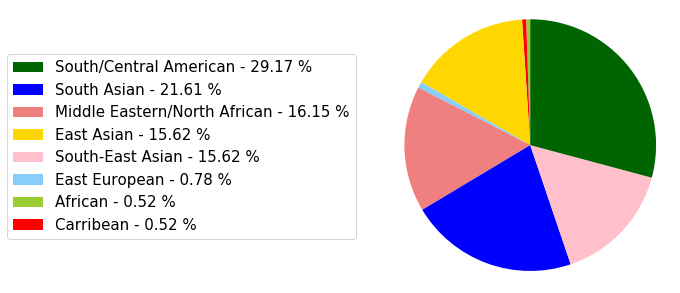

In [64]:
#plot a series of pie charts

x = np.char.array(list(top_3(a).index))
y = np.array(top_3(a)['Count 1st'])
colors = ['yellowgreen','red','gold','lightskyblue','lightcoral','blue','pink', 'darkgreen','yellow','grey','violet',
          'magenta','cyan']

percent = 100.*y/y.sum()

fig = plt.figure(figsize = (5, 5))

patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, percent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='center right', bbox_to_anchor=(-0.1, 0.5),
           fontsize=15)

plt.axis('equal')



In [ ]:
#This would suggest fairly balanced demographics, dominated by South/Central American, South Asian, Middle Eastern/
#North African, East Asian, and South-East Asian communities.

In [75]:
#cluster 1(black)

a = london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[1] + 
    list(range(5, london_merged.shape[1]))]]
a.head()

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
19,Barnsbury,East Asian,South-East Asian,Middle Eastern/North African,South Asian,African,South/Central American,East European,Carribean
20,Bassishaw,South-East Asian,East Asian,South/Central American,South Asian,Middle Eastern/North African,East European,Carribean,African
33,Beverley,East Asian,South Asian,South/Central American,South-East Asian,Middle Eastern/North African,East European,Carribean,African
38,Bishop's,East Asian,South/Central American,South-East Asian,South Asian,Middle Eastern/North African,East European,Carribean,African
39,Bishopsgate,East Asian,Middle Eastern/North African,South/Central American,South-East Asian,South Asian,East European,Carribean,African


In [73]:
top_3(a)

,Count 1st,Count 2nd,Count 3rd
Venue,,,
East Asian,26.0,9.0,1
South Asian,1.0,4.0,4
South-East Asian,8.0,13.0,6
South/Central American,1.0,4.0,12
Middle Eastern/North African,0.0,6.0,12
Carribean,0.0,0.0,1


(-1.3405236655460671,
 1.3209773416142796,
 -1.339137224288111,
 1.3209112963946719)

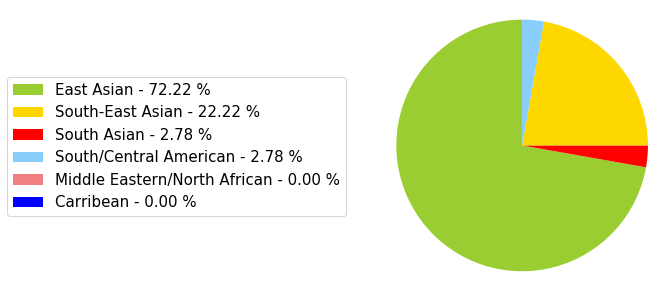

In [74]:
#plot a series of pie charts

x = np.char.array(list(top_3(a).index))
y = np.array(top_3(a)['Count 1st'])
colors = ['yellowgreen','red','gold','lightskyblue','lightcoral','blue','pink', 'darkgreen','yellow','grey','violet',
          'magenta','cyan']

percent = 100.*y/y.sum()

fig = plt.figure(figsize = (5, 5))

patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, percent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='center right', bbox_to_anchor=(-0.1, 0.5),
           fontsize=15)


plt.axis('equal')

In [44]:
#This suggests strong East Asian demographics 

In [66]:
#cluster 2 (blue)

a = london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[1] + 
    list(range(5, london_merged.shape[1]))]]
a.head()

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
1,Abbey Road,Middle Eastern/North African,South/Central American,South-East Asian,South Asian,East European,East Asian,Carribean,African
6,Addiscombe West,South-East Asian,South Asian,Middle Eastern/North African,East Asian,South/Central American,East European,Carribean,African
7,Addison,East Asian,South-East Asian,South Asian,Middle Eastern/North African,South/Central American,East European,Carribean,African
9,Aldersgate,East Asian,South-East Asian,Middle Eastern/North African,South/Central American,South Asian,East European,Carribean,African
14,Askew,Middle Eastern/North African,South Asian,East Asian,South-East Asian,South/Central American,East European,Carribean,African


In [67]:
top_3(a)

,Count 1st,Count 2nd,Count 3rd
Venue,,,
East Asian,22.0,22.0,16
Middle Eastern/North African,24.0,19.0,17
South Asian,3.0,11.0,22
South-East Asian,34.0,25.0,6
South/Central American,3.0,9.0,23
African,0.0,0.0,1
Carribean,0.0,0.0,1


(-1.3263531412648266,
 1.3414496585951343,
 -1.3300466777220807,
 1.3204784218263483)

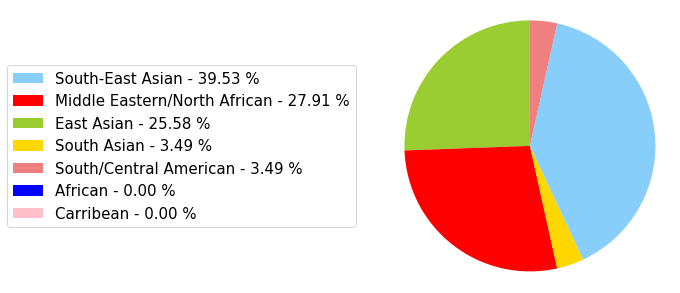

In [68]:
#plot a series of pie charts

x = np.char.array(list(top_3(a).index))
y = np.array(top_3(a)['Count 1st'])
colors = ['yellowgreen','red','gold','lightskyblue','lightcoral','blue','pink', 'darkgreen','yellow','grey','violet',
          'magenta','cyan']

percent = 100.*y/y.sum()

fig = plt.figure(figsize = (5, 5))

patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, percent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='center right', bbox_to_anchor=(-0.1, 0.5),
           fontsize=15)

plt.axis('equal')


In [48]:
#This suggest strong South-East Asian demographics, with notable Middle Eastern/North African and East 
#Asian contributions

In [69]:
#cluster 3 (red)

a = london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[1] + 
    list(range(5, london_merged.shape[1]))]]
a.head()

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
3,Abingdon,Middle Eastern/North African,South-East Asian,East Asian,South/Central American,South Asian,East European,Carribean,African
10,Aldgate,South-East Asian,Middle Eastern/North African,South/Central American,East Asian,South Asian,East European,Carribean,African
11,Alexandra,Middle Eastern/North African,East Asian,South/Central American,South-East Asian,South Asian,East European,Carribean,African
21,Bayswater,Middle Eastern/North African,South/Central American,South Asian,East Asian,South-East Asian,East European,Carribean,African
63,Brompton & Hans Town,Middle Eastern/North African,East Asian,East European,South/Central American,South Asian,South-East Asian,Carribean,African


In [70]:
top_3(a)

,Count 1st,Count 2nd,Count 3rd
Venue,,,
Middle Eastern/North African,25.0,3.0,0.0
South-East Asian,3.0,7.0,7.0
East Asian,0.0,12.0,5.0
South Asian,0.0,1.0,10.0
South/Central American,0.0,5.0,5.0
East European,0.0,0.0,1.0


(-1.327295524346062,
 1.3280517924019919,
 -1.3219466316138415,
 1.3200926967435163)

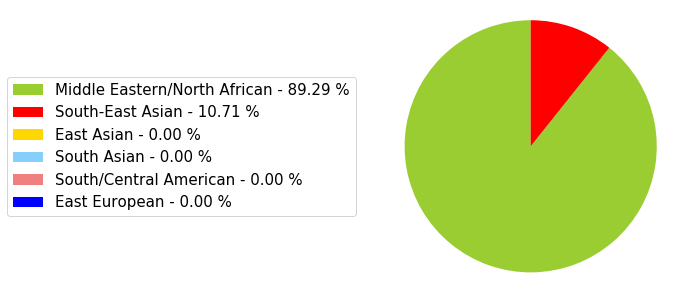

In [71]:
#plot a series of pie charts

x = np.char.array(list(top_3(a).index))
y = np.array(top_3(a)['Count 1st'])
colors = ['yellowgreen','red','gold','lightskyblue','lightcoral','blue','pink', 'darkgreen','yellow','grey','violet',
          'magenta','cyan']
percent = 100.*y/y.sum()

fig = plt.figure(figsize = (5, 5))

patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, percent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='center right', bbox_to_anchor=(-0.1, 0.5),
           fontsize=15)

plt.axis('equal')

In [52]:
#This suggests strong Middle Eastern/North African demographics

In [80]:
#cluster 4 (green)

a = london_merged.loc[london_merged['Cluster Labels'] == 4, london_merged.columns[[1] + 
    list(range(5, london_merged.shape[1]))]]
a.head()

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
13,Alperton,South Asian,Middle Eastern/North African,South/Central American,South-East Asian,East European,East Asian,Carribean,African
15,Avonmore and Brook Green,Middle Eastern/North African,South Asian,South-East Asian,South/Central American,East European,East Asian,Carribean,African
16,Balham,South Asian,Middle Eastern/North African,South/Central American,South-East Asian,East European,East Asian,Carribean,African
24,Beddington North,South Asian,South/Central American,South-East Asian,Middle Eastern/North African,East European,East Asian,Carribean,African
25,Bedfont,South Asian,South/Central American,South-East Asian,Middle Eastern/North African,East European,East Asian,Carribean,African


In [81]:
top_3(a)

,Count 1st,Count 2nd,Count 3rd
Venue,,,
East Asian,2.0,13.0,4.0
Middle Eastern/North African,1.0,16.0,7.0
South Asian,67.0,3.0,0.0
East European,0.0,2.0,0.0
South-East Asian,0.0,10.0,31.0
South/Central American,0.0,26.0,26.0
African,0.0,0.0,2.0


(-1.32876137878877,
 1.3281960435858526,
 -1.3298496130122637,
 1.3204690291910601)

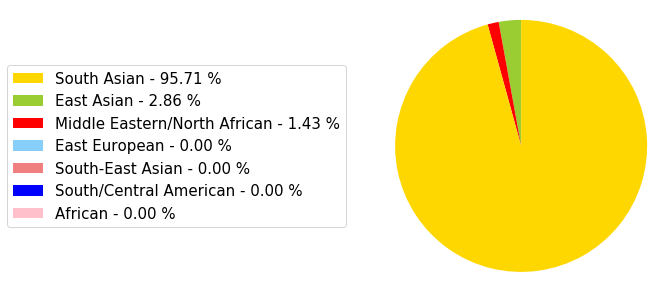

In [85]:
#plot a series of pie charts

x = np.char.array(list(top_3(a).index))
y = np.array(top_3(a)['Count 1st'])
colors = ['yellowgreen','red','gold','lightskyblue','lightcoral','blue','pink', 'darkgreen','yellow','grey','violet',
          'magenta','cyan']

percent = 100.*y/y.sum()

fig = plt.figure(figsize = (5, 5))

patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, percent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='center right', bbox_to_anchor=(-0.1, 0.5),
           fontsize=15)

plt.axis('equal')

In [78]:
#This suggests strong South Asian demographics